# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("dataset/NSE-Tata.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


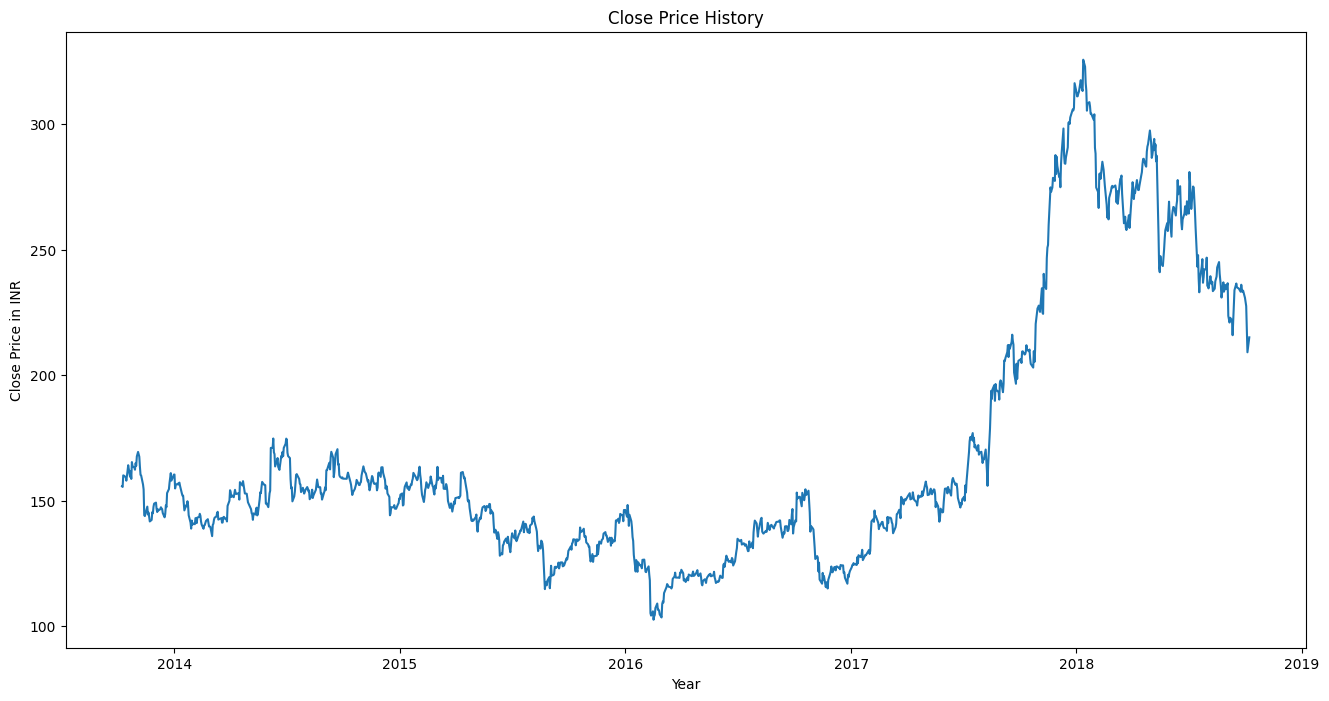

In [3]:
# Analyze the closing prices
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16, 8))
plt.plot(df['Close'])
plt.xlabel('Year')
plt.ylabel('Close Price in INR')

plt.title('Close Price History')
plt.show()

In [4]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.head()

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


In [5]:
# Normalize the new filtered dataset

scaler = MinMaxScaler(feature_range=(0, 1))
final_data = new_data.values

train_data = final_data[0:987, :]
validation_data = final_data[987:, :]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_data)

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
# Building and training the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

input_data = new_data[len(new_data) - len(validation_data) - 60:].values
input_data = input_data.reshape(-1, 1)
input_data = scaler.transform(input_data)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
29/29 - 5s - 171ms/step - loss: 0.0063
Epoch 2/20
29/29 - 1s - 45ms/step - loss: 0.0016
Epoch 3/20
29/29 - 1s - 43ms/step - loss: 0.0014
Epoch 4/20
29/29 - 1s - 50ms/step - loss: 0.0011
Epoch 5/20
29/29 - 1s - 42ms/step - loss: 0.0011
Epoch 6/20
29/29 - 1s - 46ms/step - loss: 9.5501e-04
Epoch 7/20
29/29 - 1s - 43ms/step - loss: 9.5638e-04
Epoch 8/20
29/29 - 1s - 44ms/step - loss: 9.0385e-04
Epoch 9/20
29/29 - 1s - 42ms/step - loss: 9.4919e-04
Epoch 10/20
29/29 - 1s - 40ms/step - loss: 9.2380e-04
Epoch 11/20
29/29 - 1s - 42ms/step - loss: 9.6105e-04
Epoch 12/20
29/29 - 1s - 43ms/step - loss: 8.0555e-04
Epoch 13/20
29/29 - 1s - 41ms/step - loss: 8.5277e-04
Epoch 14/20
29/29 - 1s - 45ms/step - loss: 8.7198e-04
Epoch 15/20
29/29 - 1s - 36ms/step - loss: 7.1937e-04
Epoch 16/20
29/29 - 1s - 50ms/step - loss: 7.1638e-04
Epoch 17/20
29/29 - 1s - 34ms/step - loss: 6.8529e-04
Epoch 18/20
29/29 - 1s - 38ms/step - loss: 6.5212e-04
Epoch 19/20
29/29 - 1s - 39ms/step - loss: 7.0030e-04
Ep

In [7]:
# Taking a sample of the dataset to predict the stock price
x_test = []
for i in range(60, input_data.shape[0]):
    x_test.append(input_data[i-60:i, 0])
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [8]:
model.save('model.h5')

Text(0.5, 1.0, 'Actual stock price vs Predicted Stock Price')

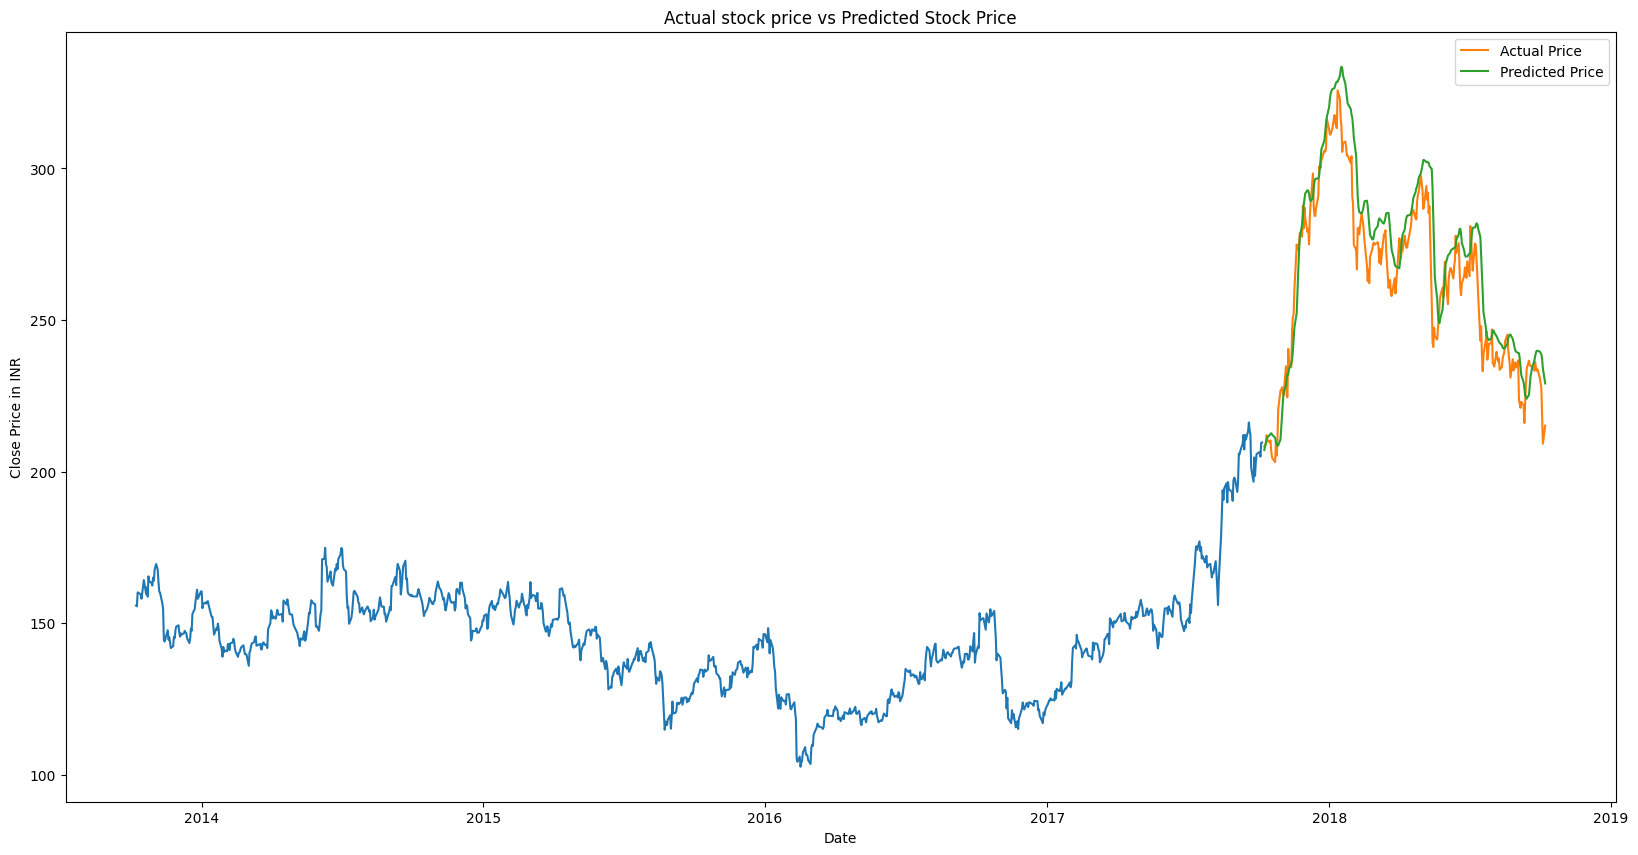

In [9]:
train_data = new_data[:987]
valid_data = new_data[987:]

valid_data['Predictions'] = predicted_stock_price

plt.plot(train_data['Close'])
plt.plot(valid_data['Close'], label='Actual Price')
plt.plot(valid_data['Predictions'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Close Price in INR')
plt.legend()

plt.title('Actual stock price vs Predicted Stock Price')